# Amplitude and Phase

The goal of this notebook is to read SLC (Single Look Complex) data and convert to amplitude and phase images.


In [1]:
# Imports
import numpy as np
import pystac_client
import odc.stac
import matplotlib.pyplot as plt
from odc.geo.geobox import GeoBox
from dask.diagnostics import ProgressBar
import rioxarray as rio
from rasterio.crs import CRS
import seaborn as sns
import xarray as xr
from pathlib import Path
import os
from skimage.restoration import unwrap_phase  # Import from skimage


In [2]:
path = r"/mnt/c/Users/npikall/mrs-data/multilooking_and_filtering"
filename = r"S1A_IW_SLC__1SDV_20230129T033452_20230129T033519_046993_05A2FE_BE0B_Orb_Stack_IW3_ifg_deb_dinsar_ML_flt_Cnv.tif"

src = Path(path) / filename
src.exists()

True

In [3]:
img = rio.open_rasterio(src)

Warning 1: TIFFFetchNormalTag:Incorrect count for "GeoTiePoints"; tag ignored
/home/npikall/miniconda3/envs/07_amplitude-and-phase/lib/python3.10/site-packages/rioxarray/_io.py:1136: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore


In [7]:
# Wrapper function to work with xarray and skimage's unwrap_phase
def unwrap_phase_xarray(da: xr.DataArray) -> xr.DataArray:
    """
    Unwraps the phase for a 2D DataArray using skimage's unwrap_phase.
    
    Parameters
    ----------
    da : xr.DataArray
        Input DataArray with phase values.
        
    Returns
    -------
    xr.DataArray
        Unwrapped phase as a DataArray.
    """
    # Apply skimage's unwrap_phase directly to the DataArray's values
    unwrapped_da_values = xr.apply_ufunc(
        unwrap_phase(wrap_around=(True, False)), 
        da,
        # input_core_dims=[['y', 'x']],  # Specify both 'y' and 'x' dimensions (rows and cols)
        # output_core_dims=[['y', 'x']],  # Ensure output dimensions match input
        # vectorize=False,  # Disable vectorization since unwrap_phase operates on arrays
        # dask='parallelized',  # Enable Dask for large datasets (if applicable)
        # output_dtypes=[float]  # Ensure the output dtype matches the unwrapped phase
    )
    
    return unwrapped_da_values

# Select the band and unwrap the phase
img_band = img.sel(band=2) #+ np.pi
unwrapped = unwrap_phase_xarray(img_band)

# Plot the result
# unwrapped#.plot(cmap='viridis', robust=True)


TypeError: unwrap_phase() missing 1 required positional argument: 'image'

In [5]:
unwrapped

<xarray.DataArray (y: 12250, x: 4188)> Size: 410MB
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
    band         int64 8B 2
  * x            (x) float64 34kB 0.0001344 0.0004033 0.0006722 ... 1.126 1.126
  * y            (y) float64 98kB -4.531e-05 -0.0001359 ... -1.11 -1.11
    spatial_ref  int64 8B 0

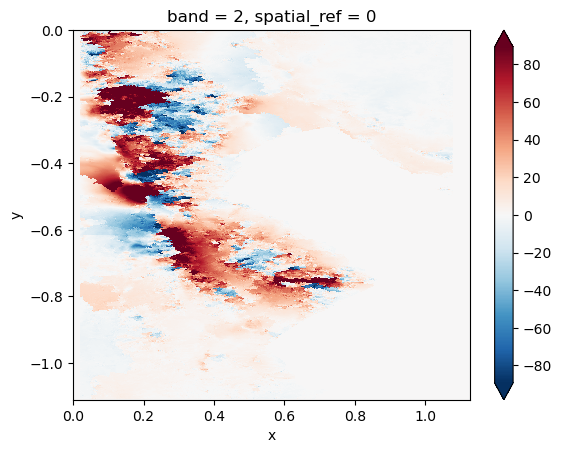

In [6]:
unwrapped.plot(robust=True)

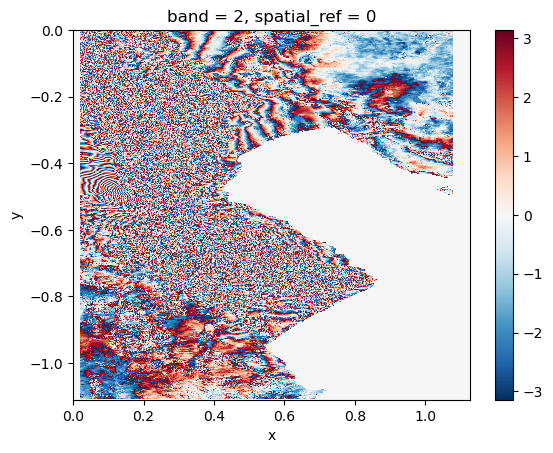

In [5]:
img.sel(band=2).plot()

In [ ]:
fig, ax = plt.subplots()
ax.imshow(unwrapped, cmap='viridis')


In [ ]:
img = rio.open_rasterio(src)

def unwrap_phase1D(ph_ar):
    """
    Parameters
    ----------
    ph_ar: np.ndarray
        Array containing phases ranging from 0 to 2pi.
        
    Returns
    -------
    np.ndarray
        Unwrapped phase array.
    """
    
    unwrapped_phs = [ph_ar[0]]
    for i in range(1, len(ph_ar)):
        prev_ph = ph_ar[i-1]
        cur_ph = ph_ar[i]
        ph_diff = cur_ph - prev_ph
        
        if abs(ph_diff) >= np.pi:
            if ph_diff < 0:
                ph_diff += 2*np.pi 
            else:
                ph_diff -= 2*np.pi 

        prev_sum = unwrapped_phs[-1]
        unwrapped_phs.append(prev_sum + ph_diff)
        
    return unwrapped_phs

unwrapped = unwrap_phase1D(img.sel(band=2).values + np.pi)

In [ ]:
unwrapped = unwrap_phase1D(img.sel(band=2).values + np.pi)

In [ ]:
catalog = pystac_client.Client.open("https://stac.eodc.eu/api/v1")
catalog.links

In [ ]:
# Search for some data
epsg = CRS.from_epsg(4326) # WGS 84 
dx = 0.0002 # degrees

# Set Spatial extent
latmin, latmax = 48, 48.5
lonmin, lonmax = 16, 17
bounds = (lonmin, latmin, lonmax, latmax)
minx, miny, maxx, maxy = bounds
geom = {
    'type': 'Polygon',
    'coordinates': [[
       [minx, miny],
       [minx, maxy],
       [maxx, maxy],
       [maxx, miny],
       [minx, miny]
    ]]
}

# Set Temporal extent
time_range = "2022-08-01/2022-08-05" # closed range

# Search for Sentinel-2 data
items = pystac_client.Client.open("https://stac.eodc.eu/api/v1").search( #alternatively use: https://earth-search.aws.element84.com/v1
    bbox=bounds,
    collections=["SENTINEL1"], # 
    datetime=time_range,
    limit=100,
).item_collection()

print(len(items), 'scenes found')